# Install the librairies and the dependences

In [1]:
!pip install --upgrade pip
!pip install pyspark
!pip install pandas==1.3.5
!pip install boto3
!pip install joblib
!pip install scikit-learn==1.0.2

# Download the models in the Notebook environment 

In [2]:
import boto3
import os

In [3]:
def download_files_in_folder(bucket_name, s3_folder_path, local_destination):
    s3 = boto3.client('s3')
    bucket = boto3.resource('s3').Bucket(bucket_name)

    for obj in bucket.objects.filter(Prefix=s3_folder_path):
        if obj.key != s3_folder_path:
            local_file_path = os.path.join(local_destination, os.path.basename(obj.key))
            os.makedirs(os.path.dirname(local_file_path), exist_ok=True)
            if not os.path.exists(local_file_path):
                s3.download_file(bucket_name, obj.key, local_file_path)

In [4]:
# bucket_name = "neo-s3-datalake-dev-ogadwv"
bucket_name = "neo-s3-datalake-pro-udaijd"
local_destination = "../../models/"
download_files_in_folder(bucket_name, "dataproduct/sohocredit/unpaidsoho/models", local_destination)

# Load the models

In [5]:
import joblib

In [6]:
def load_models(model_names):
    models = []
    for name in model_names :
        with open(f"../../models/{name}.pkl", "rb") as f:
            model = joblib.load(f)
            models.append(model)
    return models

# Load the datas 

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.utils import AnalysisException
from datetime import timedelta, datetime

In [8]:
def read_parquet(spark, path, string_date):
    i = 0
    while True:
        try:
            parquet = spark.read.parquet(path + string_date + "/")
            print("Recovering datas dating from " + str(i) + " day(s).")
            return parquet
        except AnalysisException:
            i +=1 
            date_dt = datetime.strptime(string_date, "%Y-%m-%d") - timedelta(days=1)
            string_date = str(date_dt.date())


In [9]:
def get_input_data(date_dt, bucket):
    spark = SparkSession.builder.appName('unpaid_SoHo').getOrCreate()
    
    bucket_name= bucket + "/clean/"
    
    for table, path in {
        "accountDBEram" : "sohocredit/account",
        "invoiceDBDwh" : "dwh/dwh_pl/fact_invoice_document_item",
        "customerDBDwh" : "dwh/dwh_pl/dim_customer"
    }.items() :
        read_parquet(spark, bucket_name + path + "/ingestion_date=", date_dt).createOrReplaceTempView(table)
    
    query = """
            SELECT fidi.cainvitem_amount_eur, 
                fidi.cainvitem_due_dt,
                fidi.cainvitem_clearing_dt,
                fidi.cainvitem_doc_type_code, 
                ea.rat, ea.finl_str_scr,
                ea.lcl_acty_cd, SUBSTR(dc.party_vat,3) as party_vat,
                dc.bill_address_post_code
            FROM invoiceDBDwh fidi
            JOIN customerDBDwh dc
            ON fidi.party_sk=dc.party_sk
            JOIN accountDBEram ea
            ON SUBSTR(dc.party_vat,3) = ea.acct_nbr
            WHERE (fidi.cainvitem_clearing_reason_code IN ('01', '04', '14') or fidi.cainvitem_clearing_reason_code IS NULL) and ea.acct_nbr IS NOT NULL
            limit 10000000;"""
            
    res = spark.sql(query)
        
    return res.toPandas()

# Preprocess the datas

In [10]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [11]:
def preprocess_input_data(df):
    
    # Deleting alphabetical part of the postal code 
    df['bill_address_post_code'] = df['bill_address_post_code'].str.extract('(\d+)') 
    
    cols_list = ['finl_str_scr', 'lcl_acty_cd',
                'cainvitem_amount_eur', 'party_vat', 'bill_address_post_code']
    for col in cols_list:
        df[col] = pd.to_numeric(df[col])
    
    df.columns = df.columns.str.upper()
    df = df[['PARTY_VAT','FINL_STR_SCR','RAT','LCL_ACTY_CD','CAINVITEM_AMOUNT_EUR','CAINVITEM_DUE_DT'
             ,'CAINVITEM_CLEARING_DT','CAINVITEM_DOC_TYPE_CODE','BILL_ADDRESS_POST_CODE']]

    cols_list = ['FINL_STR_SCR', 'LCL_ACTY_CD']
    df[cols_list] =  df[cols_list].fillna(0.0)
    df['RAT'].fillna('O-', inplace = True)
    df['CAINVITEM_CLEARING_DT'].fillna(string_date, inplace=True)
    df['BILL_ADDRESS_POST_CODE'].fillna(0, inplace = True) # unknown adress
    
    df=df.reset_index(drop=True)
    
    # Creating variables to predict
    df['DATEDIFF'] = (df['CAINVITEM_CLEARING_DT'] - df['CAINVITEM_DUE_DT']).dt.days
    df['VARIABLE_PREDICT_1'] = np.where(df['DATEDIFF'] > 15, 1, 0)
    df['VARIABLE_PREDICT_2'] = np.where(df['DATEDIFF'] > 30, 1, 0)
    
    # Normalizing amounts
    df_FJ = df.loc[df.CAINVITEM_DOC_TYPE_CODE == "FJ"]
    df_FV = df.loc[df.CAINVITEM_DOC_TYPE_CODE == "FV"]
    mean_amount_FJ = df_FJ.groupby("PARTY_VAT").mean()["CAINVITEM_AMOUNT_EUR"]
    mean_amount_FV = df_FV.groupby("PARTY_VAT").mean()["CAINVITEM_AMOUNT_EUR"]
    df=df.merge(mean_amount_FJ.rename('MEAN_FJ'),left_on='PARTY_VAT', right_index=True)
    df=df.merge(mean_amount_FV.rename('MEAN_FV'),left_on='PARTY_VAT', right_index=True)
    df=df[((df.CAINVITEM_AMOUNT_EUR < df.MEAN_FJ*3)&(df.CAINVITEM_AMOUNT_EUR > df.MEAN_FJ*0.5) & (df.CAINVITEM_DOC_TYPE_CODE == "FJ")) | ((df.CAINVITEM_AMOUNT_EUR < df.MEAN_FV*3)&(df.CAINVITEM_AMOUNT_EUR > df.MEAN_FV*0.5) & (df.CAINVITEM_DOC_TYPE_CODE == "FV"))]
    df = df.drop(["MEAN_FJ","MEAN_FV"], axis=1)
        
    # Special encoding for RAT score
    """
        Here I made a ranking of the RAT score.
        The company, with the most paid invoices, is the first in the ranking.
        In contrary, the companies with the most paid invoices, are the last in the ranking.
    """
    rat_names = df['RAT'].loc[df.VARIABLE_PREDICT_1 == 1].value_counts() # stores RAT names in case they need to be retrieved
    for index, val in enumerate(rat_names.items()):
        if (df['RAT'] == val[0]).any():
            df.loc[df['RAT'] == val[0] , 'RAT'] = index+1
        else : 
            df.loc[df['RAT'] == val[0] , 'RAT'] = 111
    rat_list = list(df['RAT'].unique())
    rest_rat_list = [elem for elem in rat_list if isinstance(elem, str)]
    for rat in rest_rat_list :
        df.loc[df['RAT'] == rat , 'RAT'] = 0
    
    return df

# Make predictions

In [12]:
import pandas as pd
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [13]:
def read_my_parquets(spark, path, string_date):
    i = 0
    while True:
        try:
            parquet = spark.read.parquet(path + string_date + "/")
            print("Recovering new datas dating from " + str(i) + " day(s).")
            return parquet
        except AnalysisException:
            i += 1 
            date_dt = datetime.strptime(string_date, "%Y-%m-%d") - timedelta(days=1)
            string_date = str(date_dt.date())
            if i > 7 :
                print("No new datas finded.")
                return None

In [14]:
def concatenate_df(df1, model_name, string_date, bucket):
    spark = SparkSession.builder.appName('recover_data').getOrCreate()
    bucket_name= bucket + "/dataproduct/"

    parquet = read_my_parquets(spark, bucket_name + "sohocredit/unpaidsoho/outputs/" + model_name + "/ingestion_date=", string_date)
    if parquet is not None : 
        parquet.createOrReplaceTempView("newInputs")
        
        query = """SELECT *
                FROM newInputs ni
                limit 10000000;"""
                
        res = spark.sql(query)
        
        df2 = res.toPandas()        
        df1 = pd.concat([df1, df2], axis=0, ignore_index=True)
        
        df1 = df1.sample(frac=1).reset_index(drop=True)
        
        print("New datas ingestion succeded !")
        
    return df1

In [15]:
def encode_columns(X):
    X_encoded = X.copy()
    label_encoders = {} # stock the label encoder for each column
    for column in {
        'PARTY_VAT','LCL_ACTY_CD', 'CAINVITEM_DOC_TYPE_CODE'
    } :
        encoder_column = LabelEncoder()
        X_encoded[column] = encoder_column.fit_transform(X_encoded[column])
        label_encoders[column] = encoder_column
        
    return X_encoded, label_encoders

def decode_columns(X_test, label_encoders):
    encoded_columns = ['PARTY_VAT', 'LCL_ACTY_CD', 'CAINVITEM_DOC_TYPE_CODE']
    for column in encoded_columns:
        inverse_values = label_encoders[column].inverse_transform(X_test[column])
        X_test[column + "_inverse"] = inverse_values
        
    return X_test

In [16]:
def make_predictions(df, models, model_names, string_date, bucket):
    cols_to_drop = ["CAINVITEM_DUE_DT", "CAINVITEM_CLEARING_DT",
                    "DATEDIFF", "VARIABLE_PREDICT_1"]
    df = df.drop(cols_to_drop, axis=1)
    for index, model in enumerate(models):
        
        new_df = concatenate_df(df, model_names[index], string_date, bucket)
        X, label_encoders = encode_columns(new_df) # encode also the new inputs that we've created before
   
        Y = X[X.columns[-1:]]
        X = X[X.columns[:-1]]
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=53)
        Y_pred = model.predict(X_test)
        
        # Compute accuracy
        accuracy = model.score(X_test, Y_test)
        print("Accuracy for the "+ model_names[index] + " model : " , accuracy)
        
        # Compute AUC score
        auc = metrics.roc_auc_score(Y_test, Y_pred)
        print("AUC score for the "+ model_names[index] + " model : " , auc)
        
        # Decoding of PARTY_VAT, NACE code, Doc type code
        X_test = decode_columns(X_test, label_encoders)
        
        # Creating new inputs with outputs
        outputs = pd.concat([X_test.reset_index(drop=True), pd.DataFrame((Y_pred > 0).astype(int), columns=[Y_test.columns])], axis=1)
        column_names = ['PARTY_VAT', 'FINL_STR_SCR', 'RAT', 'LCL_ACTY_CD','CAINVITEM_AMOUNT_EUR', 
                        'CAINVITEM_DOC_TYPE_CODE', 'BILL_ADDRESS_POST_CODE',"PARTY_VAT_inverse", "LCL_ACTY_CD_inverse", "CAINVITEM_DOC_TYPE_CODE_inverse", 'VARIABLE_PREDICT_2']
        outputs.rename(columns=dict(zip(outputs.columns, column_names)), inplace=True)
            
        # Ranking by attibutes with the highest number of unpaid invoices
        print("")
        print("Rank of PARTY_VAT realising the most of unpaids")
        print(outputs["PARTY_VAT_inverse"].loc[outputs.VARIABLE_PREDICT_2 == 1].value_counts())
        
        print("")
        print("Rank of NACE code realising the most of unpaids")
        print(outputs["LCL_ACTY_CD_inverse"].loc[outputs.VARIABLE_PREDICT_2 == 1].value_counts())
        
        print("")
        print("Rank of adress postal code realising the most of unpaids")
        print(outputs["BILL_ADDRESS_POST_CODE"].loc[outputs.VARIABLE_PREDICT_2 == 1].value_counts())
        
        print("")
        print("Number of unpaid by bill period")
        print(outputs["CAINVITEM_DOC_TYPE_CODE_inverse"].value_counts())
        
    return outputs, new_df

# Test

In [17]:
model_names = ['RegLog_2023_09_05', 'DecTree_2023_09_05', 'RF_2023_09_05']
dt = date.today()
string_date = dt.strftime("%Y-%m-%d") 

In [18]:
# bucket = "s3://neo-s3-datalake-dev-ogadwv"
bucket = "s3://neo-s3-datalake-pro-udaijd"

In [19]:
models = load_models(model_names)

df = get_input_data(string_date, bucket)

/home/jovyan/work/venv/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.2.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jovyan/work/venv/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jovyan/work/venv/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.2.1 when using version 1.0.2. This might l

23/09/25 07:46:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/09/25 07:46:01 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
23/09/25 07:46:04 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


Recovering datas dating from 112 day(s).
23/09/25 07:46:18 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
Recovering datas dating from 1 day(s).
Recovering datas dating from 1 day(s).


In [20]:
df.isnull().sum()

cainvitem_amount_eur            0
cainvitem_due_dt                0
cainvitem_clearing_dt       74073
cainvitem_doc_type_code         0
rat                         86665
finl_str_scr               315825
lcl_acty_cd                  3562
party_vat                       0
bill_address_post_code     173330
dtype: int64

In [21]:
cleaned_df = preprocess_input_data(df)

In [22]:
outputs, new_df = make_predictions(cleaned_df, models, model_names, string_date, bucket)

23/09/25 08:05:04 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
Recovering new datas dating from 0 day(s).


New datas ingestion succeded !
Accuracy for the RegLog_2023_09_05 model :  0.9026112722239038
AUC score for the RegLog_2023_09_05 model :  0.6901284774608567

Rank of PARTY_VAT realising the most of unpaids
447668559    661
895003063    644
403185448    353
450688526    298
877248501    296
            ... 
869995770      1
507784904      1
688774234      1
695760907      1
887941958      1
Name: PARTY_VAT_inverse, Length: 8493, dtype: int64

Rank of NACE code realising the most of unpaids
56102.0      11586
56101.0       8373
96021.0       7764
56301.0       6970
96022.0       3087
             ...  
58140.0          1
72190.0          1
23140.0          1
2221001.0        1
2100.0           1
Name: LCL_ACTY_CD_inverse, Length: 675, dtype: int64

Rank of adress postal code realising the most of unpaids
1000.0    4044
1050.0    3432
1070.0    2621
4000.0    2169
2000.0    2032
          ... 
7870.0       1
7911.0       1
5660.0       1
6820.0       1
4701.0       1
Name: BILL_ADDRESS_P

New datas ingestion succeded !
Accuracy for the DecTree_2023_09_05 model :  0.9437166918645864
AUC score for the DecTree_2023_09_05 model :  0.8917705764343136

Rank of PARTY_VAT realising the most of unpaids
204245277    2474
252151302    2321
440691388     736
471811661     534
447668559     497
             ... 
833856342       1
539937830       1
526982885       1
552668782       1
542988083       1
Name: PARTY_VAT_inverse, Length: 18059, dtype: int64

Rank of NACE code realising the most of unpaids
56102.0      7508
56101.0      6384
56301.0      5491
41201.0      3380
64200.0      3190
             ... 
19200.0         1
2511001.0       1
15200.0         1
77295.0         1
23490.0         1
Name: LCL_ACTY_CD_inverse, Length: 824, dtype: int64

Rank of adress postal code realising the most of unpaids
0.0       6960
1000.0    2479
1050.0    2341
9000.0    1747
1070.0    1742
          ... 
7502.0       1
6767.0       1
7543.0       1
3723.0       1
8554.0       1
Name: BILL_ADDRES

New datas ingestion succeded !
Accuracy for the RF_2023_09_05 model :  0.967628908174008
AUC score for the RF_2023_09_05 model :  0.8948378745402014

Rank of PARTY_VAT realising the most of unpaids
928642069    2925
204245277    2590
252151302    2365
316381138     493
471811661     448
             ... 
808181531       1
826405653       1
672659663       1
874902386       1
881789584       1
Name: PARTY_VAT_inverse, Length: 11906, dtype: int64

Rank of NACE code realising the most of unpaids
56102.0      5994
56101.0      4929
56301.0      4467
64200.0      2927
99000.0      2925
             ... 
2920111.0       1
4332001.0       1
4649201.0       1
46441.0         1
4399101.0       1
Name: LCL_ACTY_CD_inverse, Length: 712, dtype: int64

Rank of adress postal code realising the most of unpaids
0.0       6572
1000.0    4421
1050.0    1756
1070.0    1287
4000.0    1198
          ... 
1701.0       1
6769.0       1
6927.0       1
4160.0       1
6637.0       1
Name: BILL_ADDRESS_POST_CODE

### Observation to see the ouputs

In [23]:
new_df[(new_df.PARTY_VAT == 436352817)]

PARTY_VAT  FINL_STR_SCR RAT  LCL_ACTY_CD  CAINVITEM_AMOUNT_EUR  \
534106   436352817          97.0  33      68203.0                 61.00   
696910   436352817          97.0  33      68203.0                 61.00   
1466385  436352817          97.0  33      68203.0                 61.00   
1526778  436352817          97.0  33      68203.0                 61.00   
1748786  436352817          97.0  33      68203.0                 61.00   
1773796  436352817          97.0  33      68203.0                 61.00   
2467909  436352817          97.0  33      68203.0                 61.00   
2594382  436352817          97.0  33      68203.0                 61.00   
2773124  436352817          97.0  33      68203.0                 61.00   
2914699  436352817          97.0  33      68203.0                 61.00   
3210160  436352817          97.0  33      68203.0                325.63   
3241675  436352817          97.0  33      68203.0                 61.00   
3559848  436352817          97.0  33      68203.0                 61.00   
3681605  436352817          97.0  33      68203.0                 61.00   
3932427  436352817          97.0  33      68203.0                574.76   
3989960  436352817          97.0  33      68203.0                 61.00   
4295705  436352817          97.0  33      68203.0                 61.00   
4685195  436352817          97.0  33      68203.0                128.97   
4725435  436352817          97.0  33      68203.0                 61.00   
5024622  436352817          97.0  33      68203.0                 61.00   

        CAINVITEM_DOC_TYPE_CODE  BILL_ADDRESS_POST_CODE  VARIABLE_PREDICT_2  
534106                       FV                  1050.0                   0  
696910                       FV                  1050.0                   0  
1466385                      FV                  1050.0                   0  
1526778                      FV                  1050.0                   0  
1748786                      FV                  1050.0                   0  
1773796                      FV                  1050.0                   0  
2467909                      FV                  1050.0                   0  
2594382                      FV                  1050.0                   0  
2773124                      FV                  1050.0                   0  
2914699                      FV                  1050.0                   0  
3210160                      FJ                  1050.0                   0  
3241675                      FV                  1050.0                   0  
3559848                      FV                  1050.0                   0  
3681605                      FV                  1050.0                   0  
3932427                      FJ                  1050.0                   0  
3989960                      FV                  1050.0                   0  
4295705                      FV                  1050.0                   0  
4685195                      FJ                     0.0                   0  
4725435                      FV                  1050.0                   0  
5024622                      FV                  1050.0                   0

In [24]:
outputs[outputs.PARTY_VAT_inverse == 436352817]

PARTY_VAT  FINL_STR_SCR RAT  LCL_ACTY_CD  CAINVITEM_AMOUNT_EUR  \
293549       6213          97.0  33          603                128.97   
617978       6213          97.0  33          603                 61.00   
791263       6213          97.0  33          603                 61.00   
845530       6213          97.0  33          603                 61.00   
935196       6213          97.0  33          603                 61.00   

        CAINVITEM_DOC_TYPE_CODE  BILL_ADDRESS_POST_CODE  PARTY_VAT_inverse  \
293549                        0                     0.0          436352817   
617978                        1                  1050.0          436352817   
791263                        1                  1050.0          436352817   
845530                        1                  1050.0          436352817   
935196                        1                  1050.0          436352817   

        LCL_ACTY_CD_inverse CAINVITEM_DOC_TYPE_CODE_inverse  \
293549              68203.0                              FJ   
617978              68203.0                              FV   
791263              68203.0                              FV   
845530              68203.0                              FV   
935196              68203.0                              FV   

        VARIABLE_PREDICT_2  
293549                   0  
617978                   0  
791263                   0  
845530                   0  
935196                   0

### Unpaid probability

In [25]:
len(outputs.loc[(outputs.PARTY_VAT_inverse == 436352817)&(outputs.VARIABLE_PREDICT_2==1)])/len(outputs.loc[outputs.PARTY_VAT_inverse == 862555375])

0.0

In [26]:
outputs.groupby(by=["PARTY_VAT"], group_keys=True).mean().sort_values(by="VARIABLE_PREDICT_2", ascending=False)

FINL_STR_SCR  LCL_ACTY_CD  CAINVITEM_AMOUNT_EUR  \
PARTY_VAT                                                    
49579               0.0        850.0             72.000000   
42668               0.0        238.0            298.046667   
26421               1.0        536.0            374.000000   
26406               0.0        536.0            180.073750   
26405               0.0        540.0             52.823750   
...                 ...          ...                   ...   
21171               7.0        543.0             38.166667   
21172               1.0        107.0             46.470000   
21175               0.0        647.0             85.893478   
21180               2.0        290.0             69.750000   
30232              49.0        500.0             51.000000   

           CAINVITEM_DOC_TYPE_CODE  BILL_ADDRESS_POST_CODE  PARTY_VAT_inverse  \
PARTY_VAT                                                                       
49579                     1.000000                  4000.0        843384613.0   
42668                     0.666667                  8800.0        809612973.0   
26421                     1.000000                  4470.0        641744080.0   
26406                     1.000000                  9000.0        641643617.0   
26405                     0.875000                  4102.0        641633917.0   
...                            ...                     ...                ...   
21171                     1.000000                  1210.0        546623011.0   
21172                     1.000000                  8520.0        546623803.0   
21175                     0.913043                  8200.0        546640233.0   
21180                     1.000000                  9850.0        546652507.0   
30232                     1.000000                  8420.0        672347778.0   

           LCL_ACTY_CD_inverse  VARIABLE_PREDICT_2  
PARTY_VAT                                           
49579                  96040.0                 1.0  
42668                  33140.0                 1.0  
26421                  56101.0                 1.0  
26406                  56101.0                 1.0  
26405                  56301.0                 1.0  
...                        ...                 ...  
21171                  58110.0                 0.0  
21172                  18130.0                 0.0  
21175                  74300.0                 0.0  
21180                  43320.0                 0.0  
30232                  47810.0                 0.0  

[59138 rows x 8 columns]

In [27]:
outputs["PARTY_VAT_inverse"].loc[outputs.VARIABLE_PREDICT_2 == 1].value_counts()

928642069    2925
204245277    2590
252151302    2365
316381138     493
471811661     448
             ... 
808181531       1
826405653       1
672659663       1
874902386       1
881789584       1
Name: PARTY_VAT_inverse, Length: 11906, dtype: int64

In [30]:
outputs.loc[outputs.PARTY_VAT_inverse == 928642069] # encoded PARTY_VAT = 60496

PARTY_VAT  FINL_STR_SCR RAT  LCL_ACTY_CD  CAINVITEM_AMOUNT_EUR  \
22           60496          84.0   4          859                158.00   
266          60496          84.0   4          859                345.00   
991          60496          84.0   4          859                465.00   
1208         60496          84.0   4          859                559.00   
1572         60496          84.0   4          859                269.00   
...            ...           ...  ..          ...                   ...   
1283553      60496          84.0   4          859                406.00   
1284042      60496          84.0   4          859                194.00   
1284181      60496          84.0   4          859                614.00   
1284634      60496          84.0   4          859                737.18   
1285105      60496          84.0   4          859                672.22   

         CAINVITEM_DOC_TYPE_CODE  BILL_ADDRESS_POST_CODE  PARTY_VAT_inverse  \
22                             1                  1000.0          928642069   
266                            1                  1000.0          928642069   
991                            1                  1000.0          928642069   
1208                           1                  1000.0          928642069   
1572                           1                  1000.0          928642069   
...                          ...                     ...                ...   
1283553                        1                  1000.0          928642069   
1284042                        1                  1000.0          928642069   
1284181                        1                  1000.0          928642069   
1284634                        0                  1000.0          928642069   
1285105                        0                  1000.0          928642069   

         LCL_ACTY_CD_inverse CAINVITEM_DOC_TYPE_CODE_inverse  \
22                   99000.0                              FV   
266                  99000.0                              FV   
991                  99000.0                              FV   
1208                 99000.0                              FV   
1572                 99000.0                              FV   
...                      ...                             ...   
1283553              99000.0                              FV   
1284042              99000.0                              FV   
1284181              99000.0                              FV   
1284634              99000.0                              FJ   
1285105              99000.0                              FJ   

         VARIABLE_PREDICT_2  
22                        1  
266                       1  
991                       1  
1208                      1  
1572                      1  
...                     ...  
1283553                   1  
1284042                   1  
1284181                   1  
1284634                   1  
1285105                   1  

[3111 rows x 11 columns]

# Étude des données historiques

In [31]:
cleaned_df["PARTY_VAT"].loc[cleaned_df.VARIABLE_PREDICT_2 == 1].value_counts()

928642069    6863
252151302    3377
440691388    2930
204245277    1335
316381138     482
             ... 
544954710       1
555762191       1
436338266       1
878078345       1
423970865       1
Name: PARTY_VAT, Length: 19022, dtype: int64

Historique des impayés de l'entreprise 

<Axes: xlabel='CAINVITEM_CLEARING_DT'>

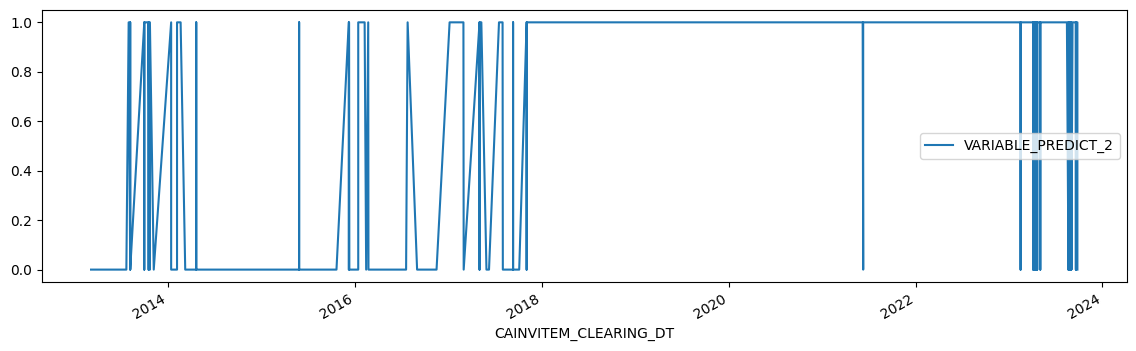

In [32]:
cleaned_df.loc[cleaned_df.PARTY_VAT == 928642069].plot(x='CAINVITEM_CLEARING_DT', y='VARIABLE_PREDICT_2', figsize=(14,4))

In [34]:
import matplotlib.pyplot as plt
import numpy as np

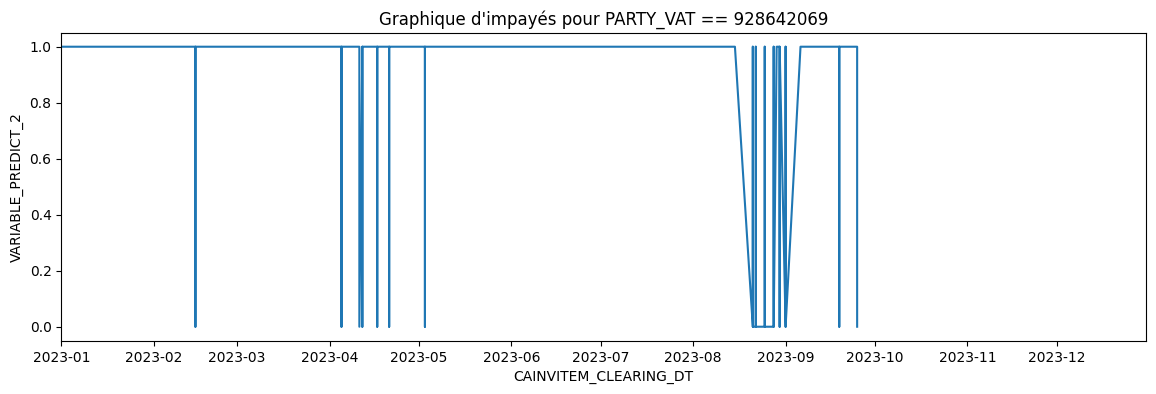

In [35]:
subset_df = cleaned_df.loc[cleaned_df.PARTY_VAT == 928642069]
subset_df = subset_df.sort_values(by='CAINVITEM_CLEARING_DT')

plt.figure(figsize=(14, 4))
plt.plot(subset_df['CAINVITEM_CLEARING_DT'], subset_df['VARIABLE_PREDICT_2'])
plt.xlabel('CAINVITEM_CLEARING_DT')
plt.ylabel('VARIABLE_PREDICT_2')
plt.title("Graphique d'impayés pour PARTY_VAT == 928642069")

plt.xlim(np.datetime64('2023-01-01'), np.datetime64('2023-12-31'))
plt.show()

Somme des unpaids réalisés par l'entreprise dans le temps

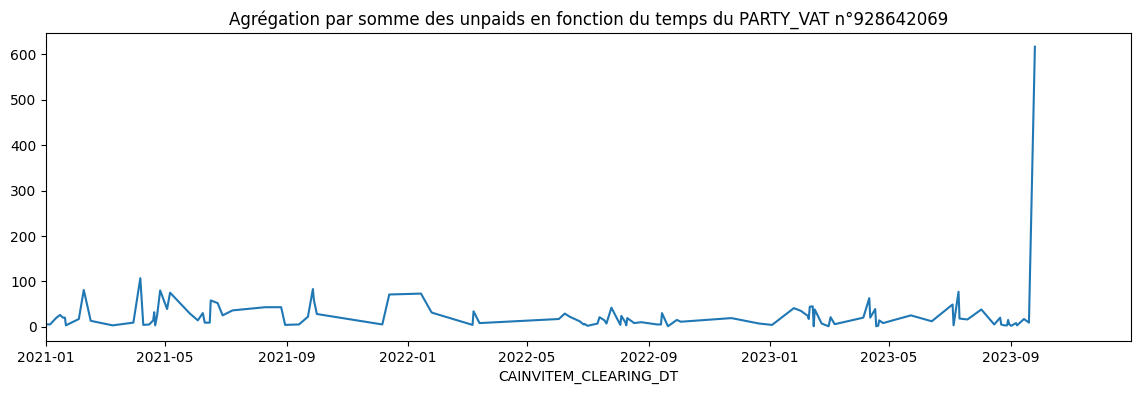

In [36]:
aggregated_df = subset_df.groupby('CAINVITEM_CLEARING_DT')['VARIABLE_PREDICT_2'].sum().reset_index()

plt.figure(figsize=(14, 4))
plt.plot(aggregated_df['CAINVITEM_CLEARING_DT'], aggregated_df['VARIABLE_PREDICT_2'])
plt.xlabel('CAINVITEM_CLEARING_DT')
plt.title('Agrégation par somme des unpaids en fonction du temps du PARTY_VAT n°928642069')
plt.xlim(np.datetime64('2021-01-01'), np.datetime64('2023-12-31'))

plt.show()

Agrégation des unpaids réalisés par toutes les entreprises

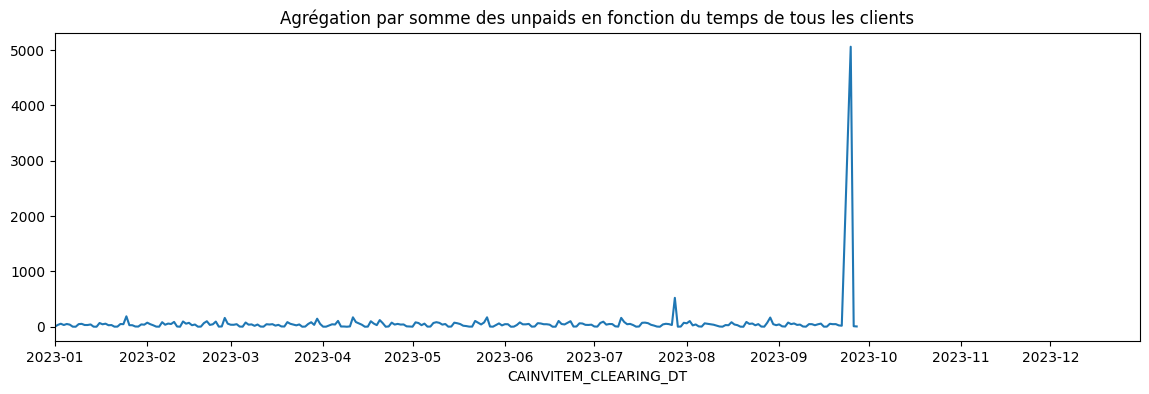

In [37]:
aggregated_df = cleaned_df.groupby('CAINVITEM_CLEARING_DT')['VARIABLE_PREDICT_2'].sum().reset_index()

plt.figure(figsize=(14, 4))
plt.plot(aggregated_df['CAINVITEM_CLEARING_DT'], aggregated_df['VARIABLE_PREDICT_2'])
plt.xlabel('CAINVITEM_CLEARING_DT')
plt.title('Agrégation par somme des unpaids en fonction du temps de tous les clients')
plt.xlim(np.datetime64('2023-01-01'), np.datetime64('2023-12-31'))

plt.show()

## Prédiction des futurs unpaids sur les derniers mois

In [38]:
aggregated_df

CAINVITEM_CLEARING_DT  VARIABLE_PREDICT_2
0               2006-05-09                   0
1               2008-01-22                   0
2               2008-02-11                   2
3               2008-03-18                   1
4               2008-03-27                   2
...                    ...                 ...
3086            2023-09-21                  24
3087            2023-09-22                  18
3088            2023-09-25                5060
3089            2023-09-26                   9
3090            2023-09-27                   5

[3091 rows x 2 columns]

## Régression ???

## Time series

In [32]:
!pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 81.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 47.6 MB/s eta 0:00:00


In [39]:
from statsmodels.tsa.arima.model import ARIMA

### Vérification de la stationarité

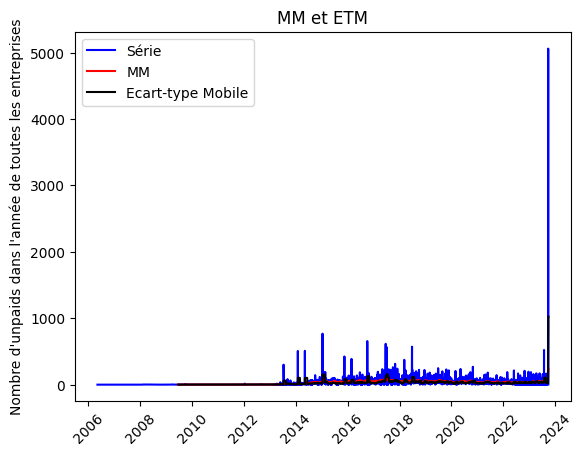

In [40]:
ts_df = aggregated_df.copy()
ts_df.set_index('CAINVITEM_CLEARING_DT', inplace=True)
rolling_mean = ts_df.rolling(window = 24).mean() #heure par heure => 1 moyenne/jour
rolling_std = ts_df.rolling(window = 24).std()
plt.plot(ts_df.index,ts_df,color='blue',label='Série')
plt.plot(ts_df.index,rolling_mean,color='red',label='MM')
plt.plot(ts_df.index,rolling_std ,color='black',label='Ecart-type Mobile')
plt.xticks(rotation=45)
plt.ylabel("Nombre d'unpaids dans l'année de toutes les entreprises")
plt.legend(loc='best')
plt.title('MM et ETM')
plt.show()

In [41]:
from statsmodels.tsa.stattools import adfuller

In [42]:
result = adfuller(ts_df)

print('Statistiques ADF = {}'.format(result[0]))
print('p-value = {}'.format(result[1]))
print('Valeurs critiques :')
for key,val in result[4].items():
    print('\t{} : {}'.format(key, val))

Statistiques ADF = -6.6971510914248
p-value = 3.973010689827917e-09
Valeurs critiques :
	1% : -3.4324728521095658
	5% : -2.8624779427668594
	10% : -2.5672692900180105


p-value < 0.05 et la série converge vers une moyenne précise => série stationaire => série dépend du temps

ARIMA (AutoRegressive Integrated Moving Average) est un modèle approprié pour modéliser des séries stationnaires.

### Recherche des ordres optimaux (p,d,q) pour le modèle ARIMA

In [43]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

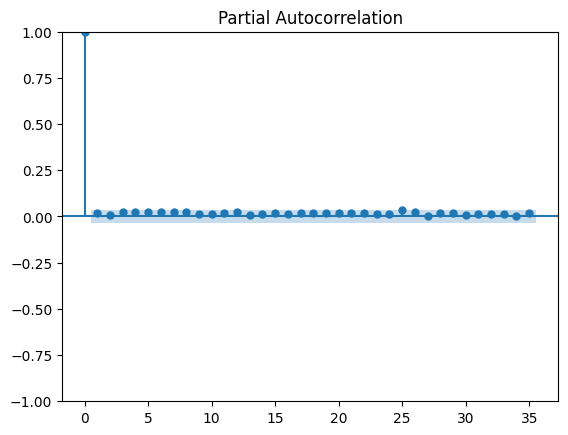

In [44]:
plot_pacf(ts_df,method='ywm')
plt.show()

p=1

On peut prendre d=0 car notre série est déja stationnaire.

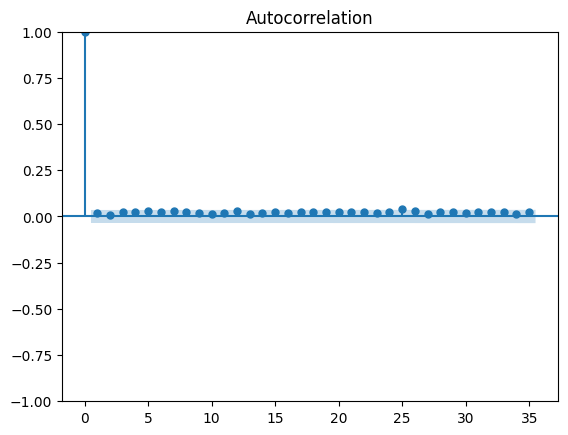

In [45]:
plot_acf(ts_df)
plt.show()

q=1

Conclusion on a (p,d,q) = (1,0,1)

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [49]:
ts_df

VARIABLE_PREDICT_2
CAINVITEM_CLEARING_DT                    
2006-05-09                              0
2008-01-22                              0
2008-02-11                              2
2008-03-18                              1
2008-03-27                              2
...                                   ...
2023-09-21                             24
2023-09-22                             18
2023-09-25                           5060
2023-09-26                              9
2023-09-27                              5

[3091 rows x 1 columns]

In [52]:
import statsmodels.api as sm

/home/jovyan/work/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/jovyan/work/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/jovyan/work/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


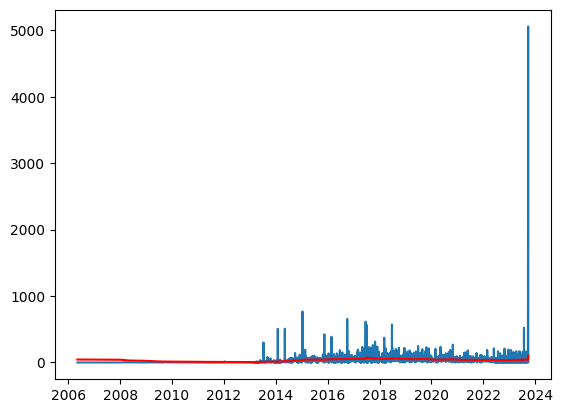

In [53]:
model = sm.tsa.arima.ARIMA(ts_df, order=(1,0,1))
results = model.fit()
plt.plot(ts_df, label='Données réelles')
plt.plot(results.fittedvalues, color='red', label='Valeurs ajustées')

In [54]:
modele_arima = ARIMA(ts_df['VARIABLE_PREDICT_2'], order=(1, 0, 1))
modele_arima_resultats = modele_arima.fit()

/home/jovyan/work/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/jovyan/work/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/jovyan/work/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [55]:
nb_month_to_predict = 3
index_futur = pd.date_range(start=ts_df.index[-1], periods=nb_month_to_predict, freq='MS')
predictions, stderr, conf_int = modele_arima_resultats.forecast(steps=nb_month_to_predict)
predictions_df = pd.DataFrame(predictions, index=index_futur, columns=['VARIABLE_PREDICT_2'])

/home/jovyan/work/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/jovyan/work/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Prédictions pour les mois 10, 11, 12 :
             VARIABLE_PREDICT_2
2023-10-01          100.696985
2023-11-01          100.696985
2023-12-01          100.696985


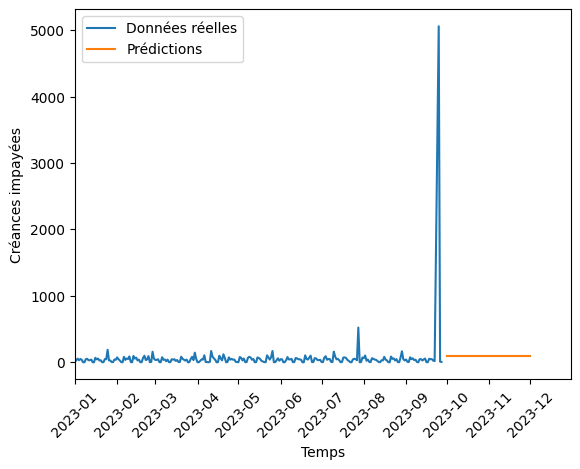

In [56]:
print("Prédictions pour les mois 10, 11, 12 :\n", predictions_df)

# Affichage du graphique
plt.plot(ts_df.index, ts_df['VARIABLE_PREDICT_2'], label='Données réelles')
plt.plot(predictions_df.index, predictions_df['VARIABLE_PREDICT_2'], label='Prédictions')
plt.xlim(np.datetime64('2023-01-01'), np.datetime64('2023-12-31'))
plt.xticks(rotation=45)
plt.xlabel('Temps')
plt.ylabel('Créances impayées')
plt.legend()
plt.show()

Les clients qui rélaisent le plus d'unpaids depuis 2023

In [57]:
cleaned_df.loc[(cleaned_df.CAINVITEM_CLEARING_DT > np.datetime64('2023-01-01'))].value_counts() 

PARTY_VAT  FINL_STR_SCR  RAT  LCL_ACTY_CD  CAINVITEM_AMOUNT_EUR  CAINVITEM_DUE_DT  CAINVITEM_CLEARING_DT  CAINVITEM_DOC_TYPE_CODE  BILL_ADDRESS_POST_CODE  DATEDIFF  VARIABLE_PREDICT_1  VARIABLE_PREDICT_2
433943950  93.0          11   41201.0      121.00                2023-01-15        2023-01-25             FJ                       1170.0                   10       0                   0                     234
834764974  95.0          35   68203.0      100.00                2023-08-08        2023-08-08             FV                       7000.0                   0        0                   0                      64
433943950  93.0          11   41201.0      121.00                2023-01-28        2023-01-25             FJ                       1170.0                  -3        0                   0                      63
439077032  95.0          20   41201.0      9.00                  2023-06-08        2023-06-06             FV                       8377.0                  -2      

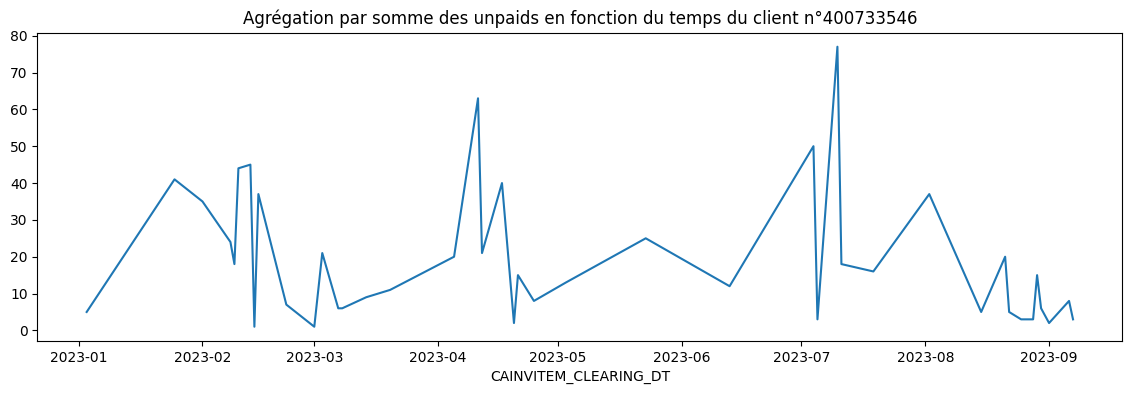

In [52]:
df_400733546 = cleaned_df.loc[(cleaned_df.DUNS_NBR == 47750)&(cleaned_df.CAINVITEM_CLEARING_DT > np.datetime64('2023-01-01'))] #400733546
df_400733546 = df_400733546.sort_values(by='CAINVITEM_CLEARING_DT')

aggregated_df = df_400733546.groupby('CAINVITEM_CLEARING_DT')['VARIABLE_PREDICT_2'].sum().reset_index()

plt.figure(figsize=(14, 4))
plt.plot(aggregated_df['CAINVITEM_CLEARING_DT'], aggregated_df['VARIABLE_PREDICT_2'])
plt.xlabel('CAINVITEM_CLEARING_DT')
plt.title('Agrégation par somme des unpaids en fonction du temps du client n°400733546')

plt.show()